In [1]:
!pip install tensorflow numpy pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

2024-06-04 12:20:57.099693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 12:20:57.099798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 12:20:57.239107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from matplotlib.patches import Circle
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import average_precision_score 
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from matplotlib import cm
from sklearn.model_selection import train_test_split

In [4]:
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
%matplotlib inline

In [5]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.15.0


In [6]:
# Download the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 15s 0us/step


In [7]:
#split the data into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [8]:
#print the shape of the data

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)


In [9]:
# CIFAR-10  classes as a list
label_list = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

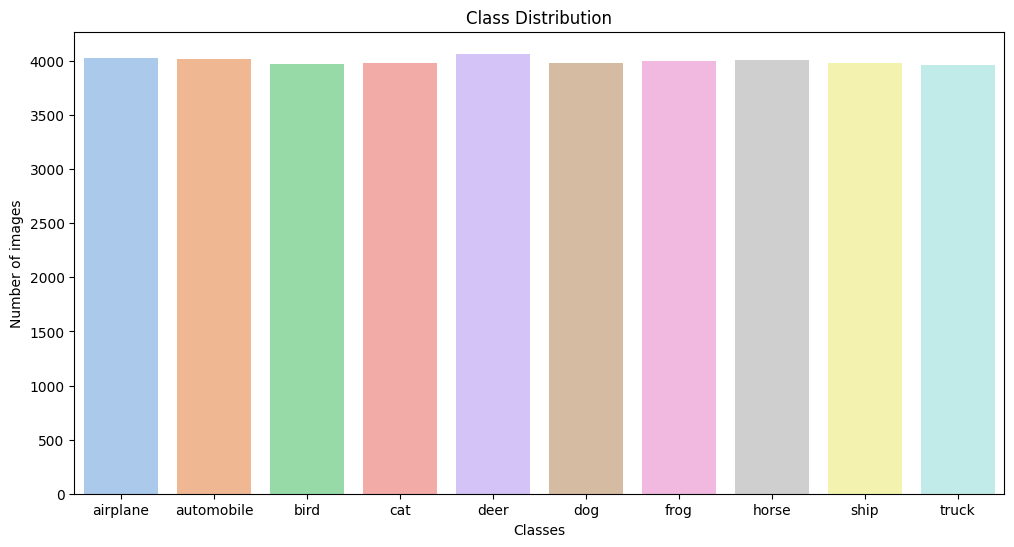

In [10]:
# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(label_list, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])


# Plot the class distribution of the training set
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=class_counts_df ,palette='pastel')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of images')
#plt.xticks(rotation=45)
plt.show()

In [11]:
class_counts_df

,Class,Count
0,airplane,4027
1,automobile,4021
2,bird,3970
3,cat,3977
4,deer,4067
5,dog,3985
6,frog,4004
7,horse,4006
8,ship,3983
9,truck,3960


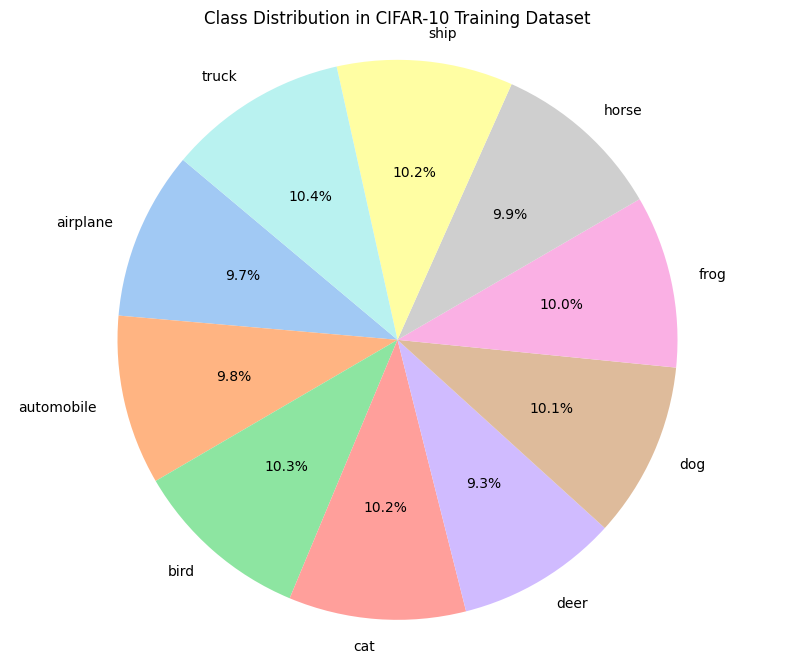

In [12]:
unique, counts = np.unique(y_val, return_counts=True)
class_counts = dict(zip(label_list, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])


# Plot the class distribution of the validation set
plt.figure(figsize=(10, 8))
plt.pie(class_counts_df['Count'], labels=class_counts_df['Class'], 
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', len(label_list)))

plt.title('Class Distribution in CIFAR-10 Training Dataset') 
plt.axis('equal')
plt.show()

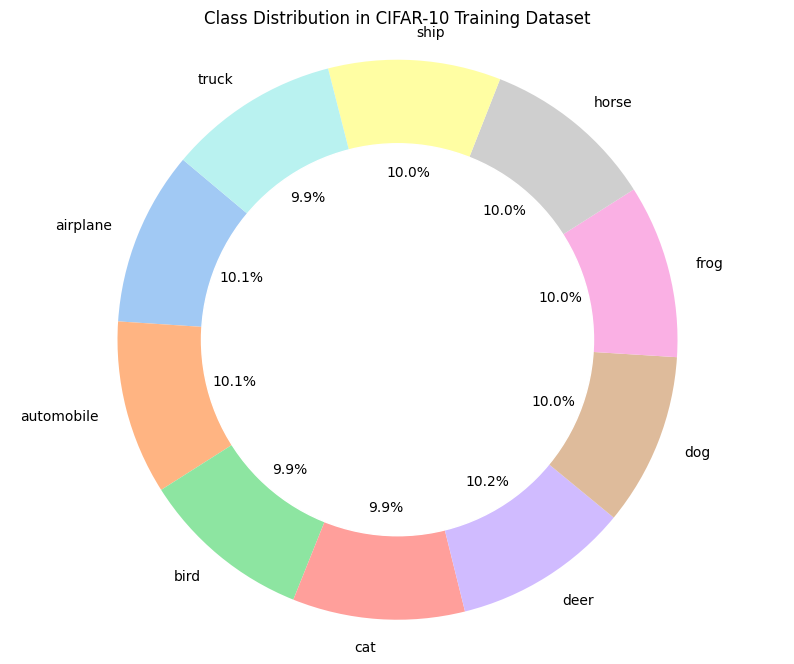

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(label_list, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])


# Plot the class distribution of the training set

plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(class_counts_df['Count'], labels=class_counts_df['Class'], 
                                   autopct='%1.1f%%', startangle=140, 
                                   colors=sns.color_palette('pastel', len(label_list)))

circle = Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

plt.axis('equal')
plt.title('Class Distribution in CIFAR-10 Training Dataset')
plt.show()

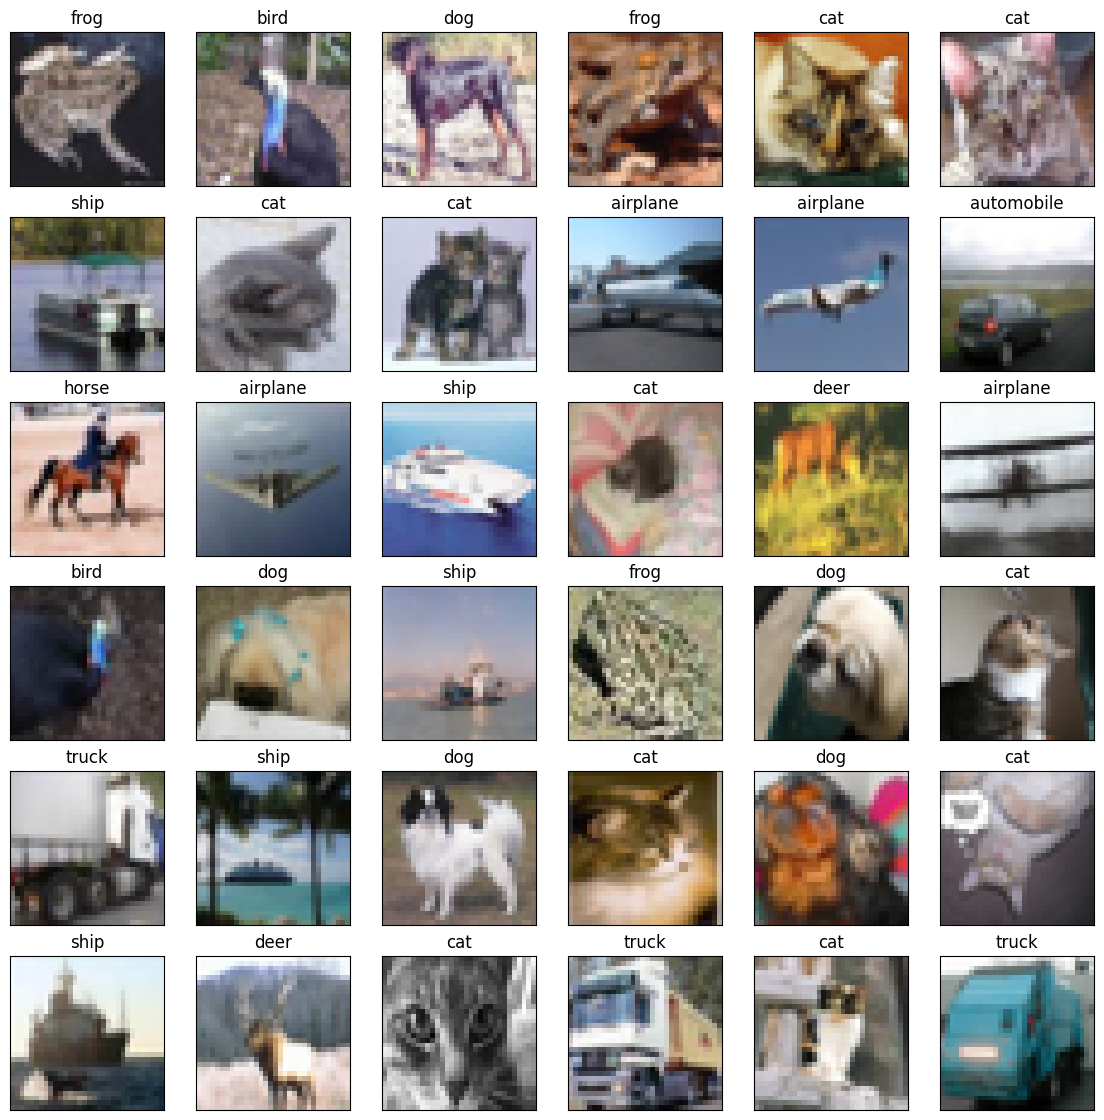

In [14]:
# let's visualize some of the images in the dataset

fig, axes = plt.subplots(6, 6, figsize=(14, 14))

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False) 
    plt.imshow(x_train[i]) 
    plt.title(label_list[y_train[i][0]])
    
plt.show()


# Data Preprocessing
### * Normalization
### * Encoding
### * Data Augmentation

In [15]:
# pixel values to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

In [16]:
mean = np.mean(x_train)
std = np.std(x_train)
print(mean)
print(std)


120.73008
64.074066


In [17]:
# Normalization
x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)
x_val = (x_val - mean) / (std+1e-7)


In [18]:
# Encoding the labels
# converting the class labels into one-hot vectors
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

In [19]:
# Data Augmentation
datagen = ImageDataGenerator( 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    zoom_range=0.3, 
    brightness_range=[0.8,1.2], 
    channel_shift_range=0.2
)

In [20]:
input_shape = x_train.shape[1:]

input_shape

(32, 32, 3)

 # Create the ZFNet model

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_zfnet(input_shape):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(96, (7, 7), strides=(2, 2), padding='same', activation='relu', 
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # Second convolutional layer
    model.add(layers.Conv2D(256, (5, 5), 
                            strides=(2, 2), 
                            padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # Third convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Fourth convolutional layer
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Fifth convolutional layer
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # Flatten the input
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    return model

# Create the model
zfnet_model = create_zfnet(input_shape)


optimizer = Adam(learning_rate=0.001)
# Compile the model
zfnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
zfnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 96)        14208     
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 96)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 384)         1

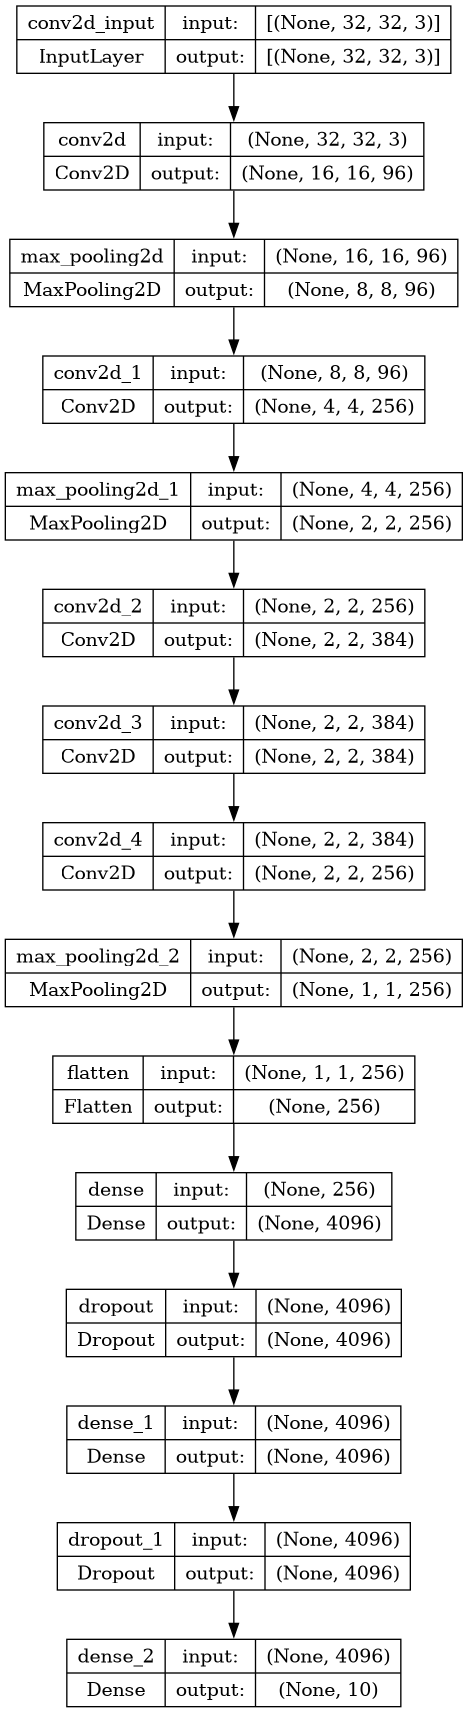

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(zfnet_model, to_file='zfnet_model.png', show_shapes=True, show_layer_names=True,
            dpi=96, expand_nested=True)



In [23]:
# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                               verbose=1, mode='auto', restore_best_weights=True)

In [24]:
batch_size = 64
epochs = 100

steps_per_epoch=x_train.shape[0] // batch_size

steps_per_epoch # optimize this your ram OR Vram 

625

In [25]:
# Train the model

history = zfnet_model.fit(x_train, y_train, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                            callbacks=[learning_rate_reduction, early_stopping],
                            verbose=1)


Epoch 1/100


I0000 00:00:1717503696.578211      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 15s 14ms/step - loss: 1.7884 - accuracy: 0.2990 - val_loss: 1.4969 - val_accuracy: 0.4393 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - 8s 12ms/step - loss: 1.4361 - accuracy: 0.4636 - val_loss: 1.3067 - val_accuracy: 0.5186 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - 8s 12ms/step - loss: 1.2664 - accuracy: 0.5462 - val_loss: 1.2413 - val_accuracy: 0.5566 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - 8s 12ms/step - loss: 1.1745 - accuracy: 0.5804 - val_loss: 1.1441 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 5/100
625/625 [==============================] - 8s 12ms/step - loss: 1.1001 - accuracy: 0.6120 - val_loss: 1.1638 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 6/100
625/625 [==============================] - 8s 12ms/step - loss: 1.0483 - accuracy: 0.6310 - val_loss: 1.0951 - val_accuracy: 0.6229 - lr: 0.0010
Epoch 7/100
625/625 [==============================] - 8s 12ms/step -

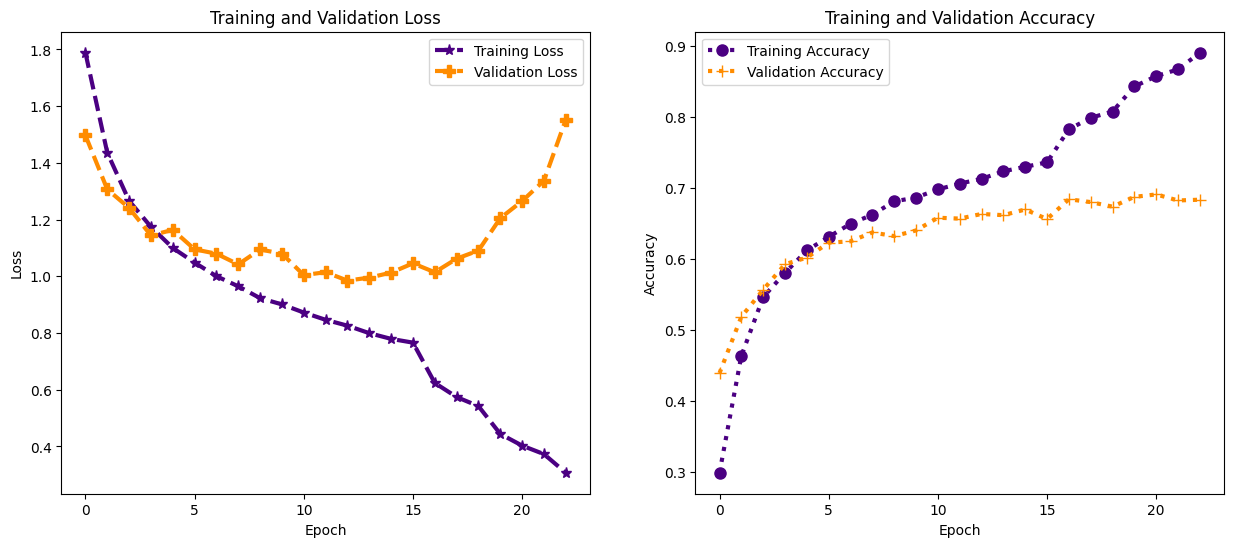

In [26]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss',
         color='indigo',marker="*",lw=3,markersize=8,linestyle="--")
plt.plot(history.history['val_loss'], label='Validation Loss',
         color='darkorange',marker="P",lw=3,markersize=8,linestyle="--")

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy',
         color='indigo',marker="o",lw=3,markersize=8,linestyle=":")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',
            color='darkorange',marker="+",lw=3,markersize=8,linestyle=":")

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = zfnet_model.evaluate(x_test, y_test, verbose=1)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 1s 4ms/step - loss: 1.0025 - accuracy: 0.6618
Test loss: 1.0024629831314087
Test accuracy: 0.6618000268936157


In [28]:
# Save the model
#zfnet_model.save('zfnet_model.h5') #old code 
zfnet_model.save('zfnet_model.keras')

In [29]:
# predict the class of the test set
predictions = zfnet_model.predict(x_test)
final_pred = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)


313/313 [==============================] - 1s 3ms/step


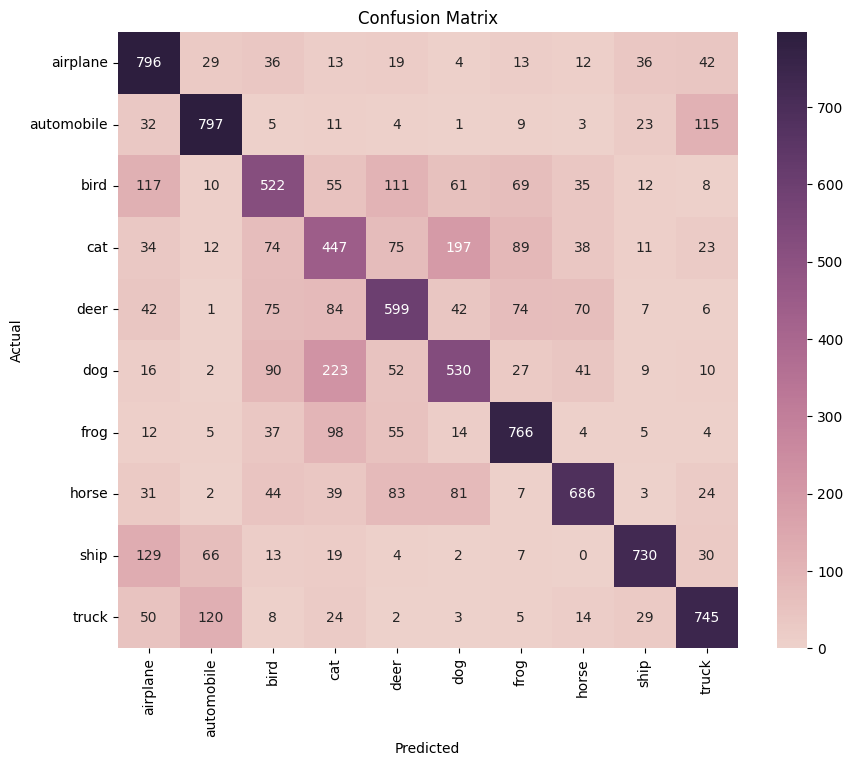

In [30]:
from sklearn.metrics import (classification_report, confusion_matrix ,roc_curve,roc_auc_score, log_loss,
                             accuracy_score, precision_score, recall_score, f1_score, 
                             cohen_kappa_score , matthews_corrcoef , brier_score_loss)
import seaborn as sns

confusion_matrix = confusion_matrix(y_test_labels, final_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), 
            xticklabels=label_list, yticklabels=label_list)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [31]:
# Classification report
print(classification_report(y_test_labels, final_pred, target_names=label_list))

              precision    recall  f1-score   support

    airplane       0.63      0.80      0.70      1000
  automobile       0.76      0.80      0.78      1000
        bird       0.58      0.52      0.55      1000
         cat       0.44      0.45      0.44      1000
        deer       0.60      0.60      0.60      1000
         dog       0.57      0.53      0.55      1000
        frog       0.72      0.77      0.74      1000
       horse       0.76      0.69      0.72      1000
        ship       0.84      0.73      0.78      1000
       truck       0.74      0.74      0.74      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



In [32]:
report = classification_report(y_test_labels, final_pred, target_names=label_list, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
airplane,0.632248,0.7960,0.704737,1000.0000
automobile,0.763410,0.7970,0.779843,1000.0000
bird,0.577434,0.5220,0.548319,1000.0000
cat,0.441264,0.4470,0.444113,1000.0000
deer,0.596614,0.5990,0.597804,1000.0000
dog,0.566845,0.5300,0.547804,1000.0000
frog,0.718574,0.7660,0.741530,1000.0000
horse,0.759690,0.6860,0.720967,1000.0000
ship,0.843931,0.7300,0.782842,1000.0000
truck,0.739821,0.7450,0.742402,1000.0000


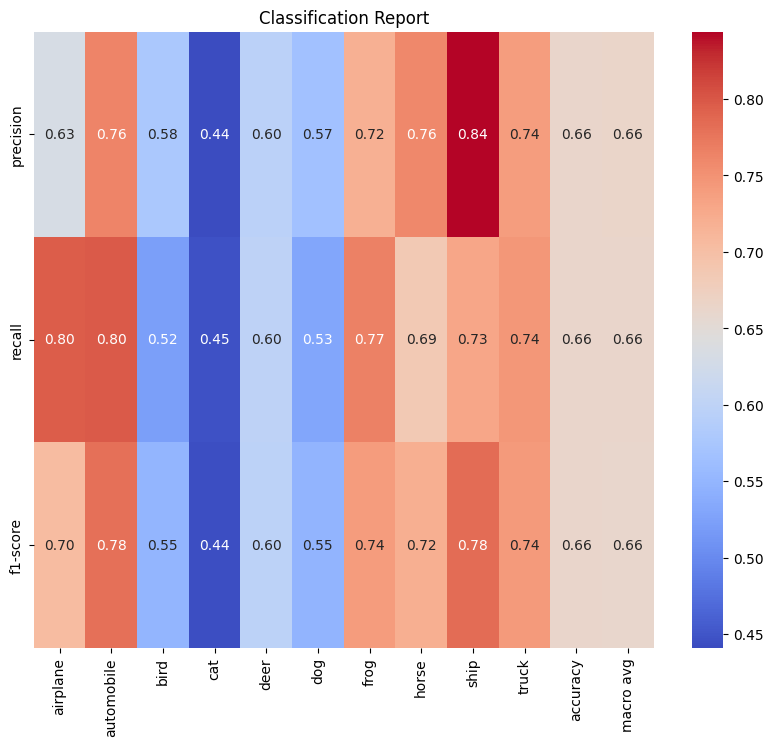

In [33]:
# Plot the classification report
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()

In [34]:
# Classification metrics definitions
# Accuracy
accuracy = accuracy_score(y_test_labels, final_pred)
# Precision
precision = precision_score(y_test_labels, final_pred, average='weighted')
# Recall
recall = recall_score(y_test_labels, final_pred, average='weighted')
# F1 score
f1 = f1_score(y_test_labels, final_pred, average='weighted')
# roc_auc_score
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')
# cohen_kappa_score
cohen_kappa = cohen_kappa_score(y_test_labels, final_pred)
# matthews_corrcoef
mcc = matthews_corrcoef(y_test_labels, final_pred)


In [35]:
# Print the classification metrics scores list

metrics_scores = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC Score': roc_auc,
    'Cohen Kappa Score': cohen_kappa,
    'Matthews Correlation Coefficient': mcc
}
# data frame of the metrics scores 
metrics_scores_df = pd.DataFrame(list(metrics_scores.items()), columns=['Metric', 'Score'])

metrics_scores_df


,Metric,Score
0,Accuracy,0.661800
1,Precision,0.663983
2,Recall,0.661800
3,F1 Score,0.661036
4,ROC AUC Score,0.939943
5,Cohen Kappa Score,0.624222
6,Matthews Correlation Coefficient,0.624620


In [36]:
# metrics scorces df each class
# Precision, Recall, F1 Score, Support
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for class_label in range(len(label_list)):
    class_report = classification_report(y_test_labels, final_pred, output_dict=True)
    accuracy_list.append(class_report[str(class_label)]['f1-score'])
    precision_list.append(class_report[str(class_label)]['precision'])
    recall_list.append(class_report[str(class_label)]['recall'])
    f1_list.append(class_report[str(class_label)]['f1-score'])
    
class_metrics_df = pd.DataFrame()
class_metrics_df['Class'] = label_list
class_metrics_df['Precision'] = precision_list
class_metrics_df['Recall'] = recall_list
class_metrics_df['F1 Score'] = f1_list

class_metrics_df

,Class,Precision,Recall,F1 Score
0,airplane,0.632248,0.796,0.704737
1,automobile,0.763410,0.797,0.779843
2,bird,0.577434,0.522,0.548319
3,cat,0.441264,0.447,0.444113
4,deer,0.596614,0.599,0.597804
5,dog,0.566845,0.530,0.547804
6,frog,0.718574,0.766,0.741530
7,horse,0.759690,0.686,0.720967
8,ship,0.843931,0.730,0.782842
9,truck,0.739821,0.745,0.742402


In [37]:
num_classes = len(label_list)

In [38]:
# brier score loss each class df

brier_score_loss_list = []
brier_score_loss_df = pd.DataFrame()

for class_label in range(num_classes):
    class_mask = (y_test_labels == class_label)
    class_predictions = (final_pred == class_label)
    brier_score = brier_score_loss(class_mask, class_predictions)
    brier_score_loss_list.append(brier_score)
    
brier_score_loss_df['Class'] = label_list
brier_score_loss_df['Brier Score Loss'] = brier_score_loss_list

brier_score_loss_df


,Class,Brier Score Loss
0,airplane,0.0667
1,automobile,0.0450
2,bird,0.0860
3,cat,0.1119
4,deer,0.0806
5,dog,0.0875
6,frog,0.0534
7,horse,0.0531
8,ship,0.0405
9,truck,0.0517


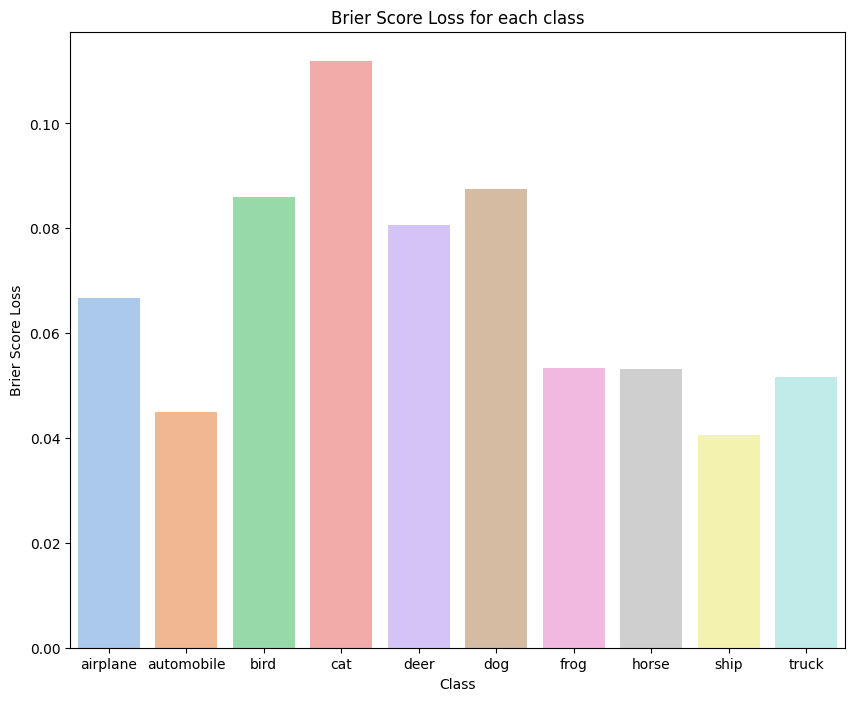

In [39]:
#Bar plot of the Brier Score Loss for each class
plt.figure(figsize=(10, 8),facecolor='w')

sns.barplot(x='Class', y='Brier Score Loss', data=brier_score_loss_df, palette='pastel')
plt.title('Brier Score Loss for each class')
plt.ylabel('Brier Score Loss')
plt.xlabel('Class')
plt.show()

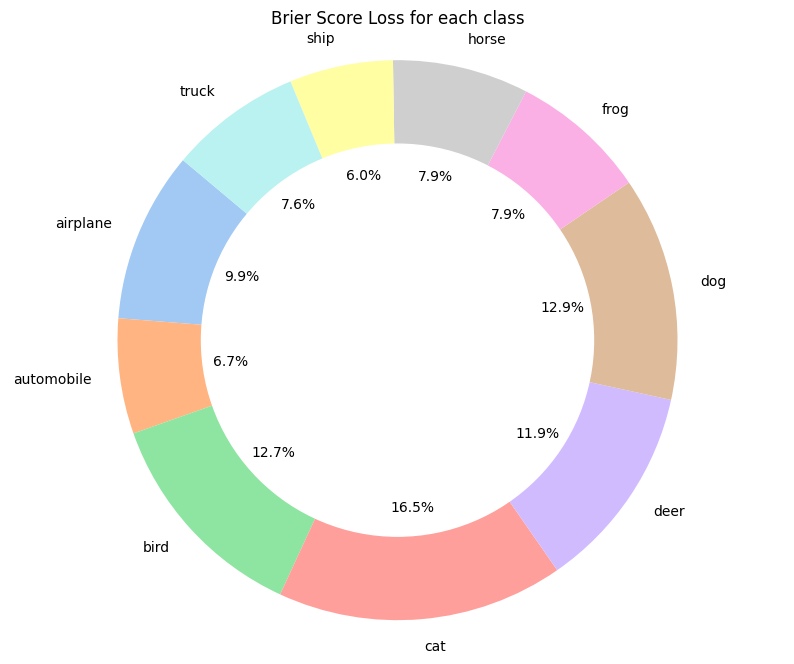

In [40]:
# circular plot of the Brier Score Loss for each class
plt.figure(figsize=(10, 8),facecolor='w')

wedges, texts, autotexts = plt.pie(brier_score_loss_df['Brier Score Loss'], labels=brier_score_loss_df['Class'],
                                      autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', num_classes))

circle = Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

plt.axis('equal')
plt.title('Brier Score Loss for each class')
plt.show()



In [41]:
# precisions recals each class df

precision_list = []
recall_list = []
precision_recal_df = pd.DataFrame()

for class_label in range(num_classes):
    class_mask = (y_test_labels == class_label)
    class_predictions = (final_pred == class_label)
    
    precision = precision_score(class_mask, class_predictions)
    recall = recall_score(class_mask, class_predictions)
    
    precision_list.append(precision)
    recall_list.append(recall)
    
precision_recal_df['Class'] = label_list
precision_recal_df['Precision'] = precision_list
precision_recal_df['Recall'] = recall_list

precision_recal_df

,Class,Precision,Recall
0,airplane,0.632248,0.796
1,automobile,0.763410,0.797
2,bird,0.577434,0.522
3,cat,0.441264,0.447
4,deer,0.596614,0.599
5,dog,0.566845,0.530
6,frog,0.718574,0.766
7,horse,0.759690,0.686
8,ship,0.843931,0.730
9,truck,0.739821,0.745


<Figure size 1000x800 with 0 Axes>

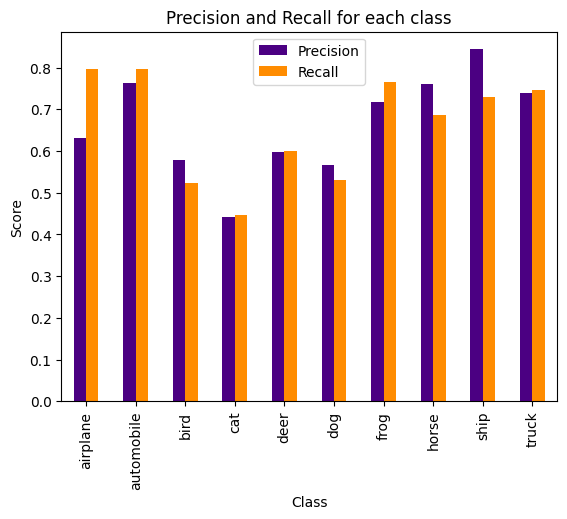

In [42]:
#Bar plot of the Precision and Recall for each class

plt.figure(figsize=(10, 8),facecolor='w')
precision_recal_df.plot(x='Class', y=['Precision', 'Recall'], kind='bar', color=['indigo', 'darkorange'])
plt.title('Precision and Recall for each class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.show()

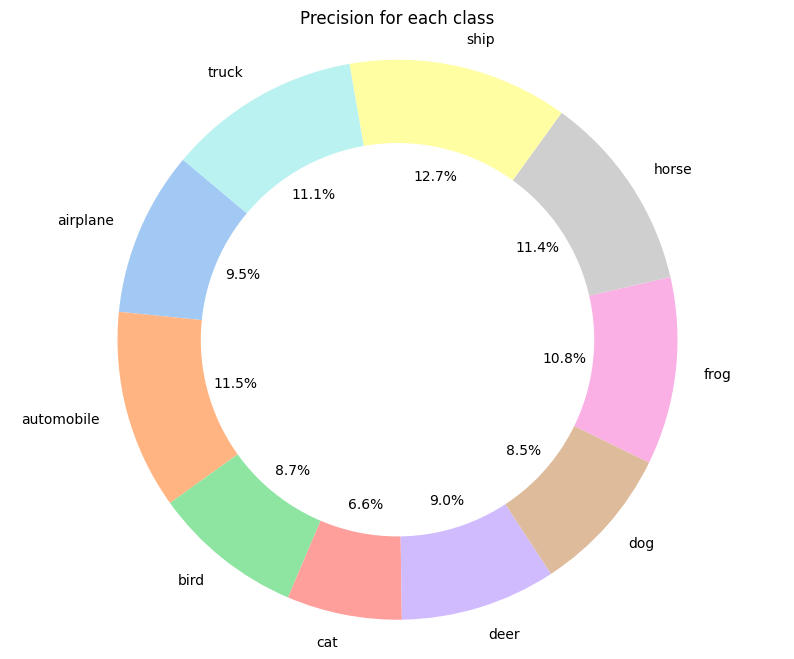

In [43]:
# circular plot of the Precision and Recall for each class

plt.figure(figsize=(10, 8),facecolor='w')

wedges, texts, autotexts = plt.pie(precision_recal_df['Precision'], labels=precision_recal_df['Class'],
                                        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', num_classes))

circle = Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

plt.axis('equal')
plt.title('Precision for each class')
plt.show()


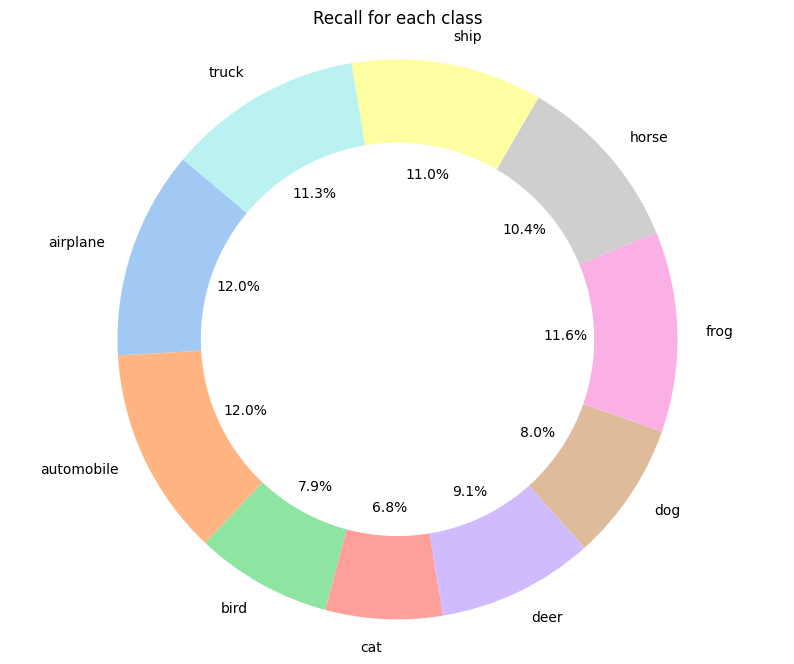

In [44]:
# circular plot of the Precision and Recall for each class

plt.figure(figsize=(10, 8),facecolor='w')

wedges, texts, autotexts = plt.pie(precision_recal_df['Recall'], labels=precision_recal_df['Class'],
                                        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', num_classes))

circle = Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

plt.axis('equal')
plt.title('Recall for each class')
plt.show()


/tmp/ipykernel_24/3821157772.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Pastel1', num_classes)


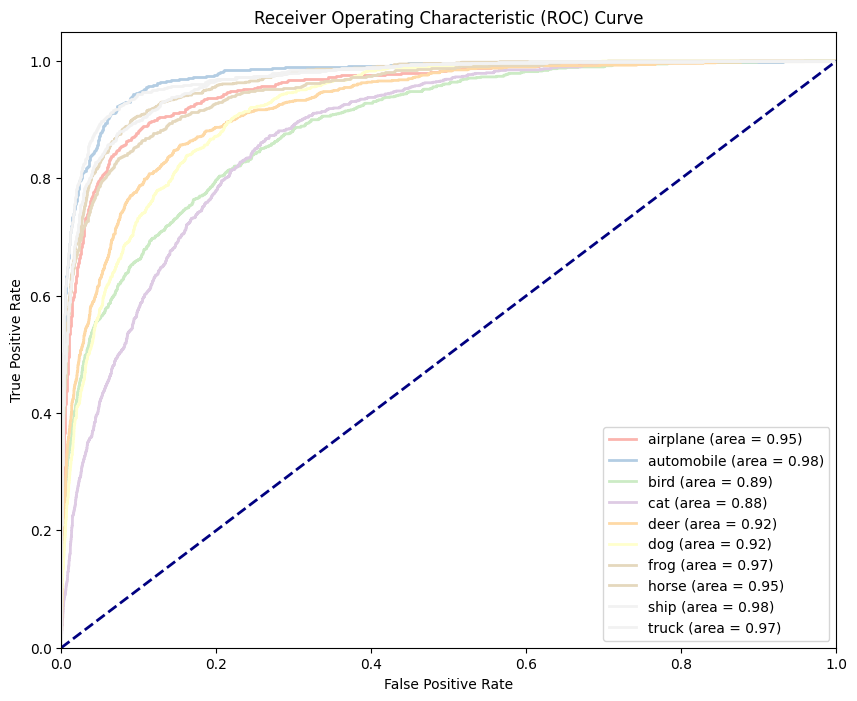

In [45]:
#  roc curve 

fpr = dict()
tpr = dict()
roc_auc = dict()

for class_index in range(num_classes):
    
    class_mask = (y_test_labels == class_index)
    fpr[class_index], tpr[class_index], _ = roc_curve(class_mask.astype(int) , predictions[:,class_index]) 
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    
# plot the roc curves
plt.figure(figsize=(10, 8))

#colors pastel 
colors = cm.get_cmap('Pastel1', num_classes)

for class_index in range(num_classes):
    plt.plot(fpr[class_index], tpr[class_index], color=colors(class_index), lw=2, label=f'{label_list[class_index]} (area = {roc_auc[class_index]:0.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

/tmp/ipykernel_24/239172915.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Pastel1', num_classes)


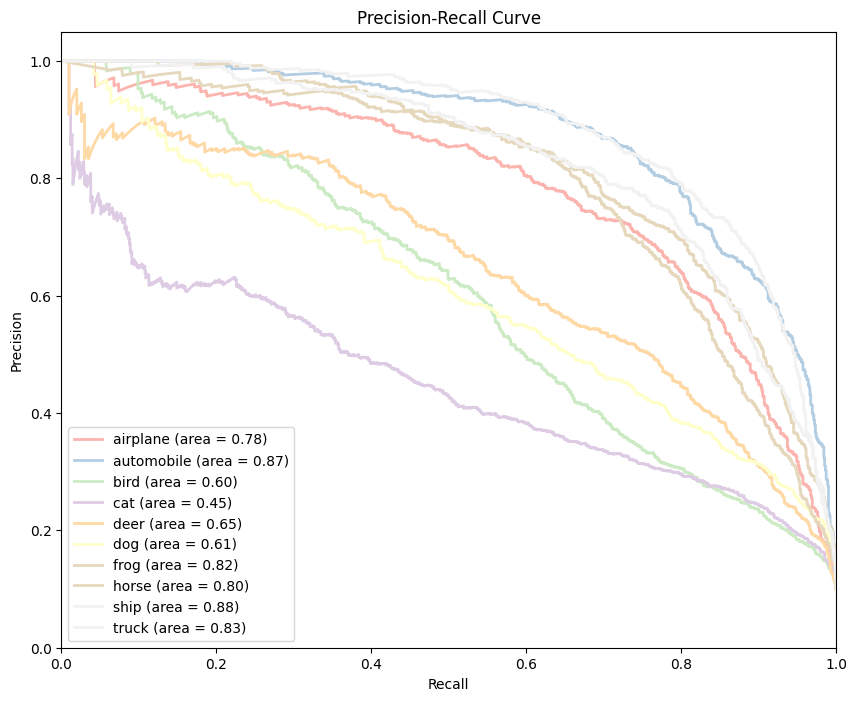

In [46]:
# precision-recall curve

precision = dict()
recall = dict()
average_precision = dict()

for class_index in range(num_classes):
    
    class_mask = (y_test_labels == class_index)
    precision[class_index], recall[class_index], _ = precision_recall_curve(class_mask.astype(int), predictions[:,class_index])
    average_precision[class_index] = average_precision_score(class_mask.astype(int), predictions[:,class_index])
    
# plot the precision-recall curves
plt.figure(figsize=(10, 8))

#colors pastel
colors = cm.get_cmap('Pastel1', num_classes)

for class_index in range(num_classes):
    plt.plot(recall[class_index], precision[class_index], color=colors(class_index), lw=2, label=f'{label_list[class_index]} (area = {average_precision[class_index]:0.2f})')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()


## Prediction

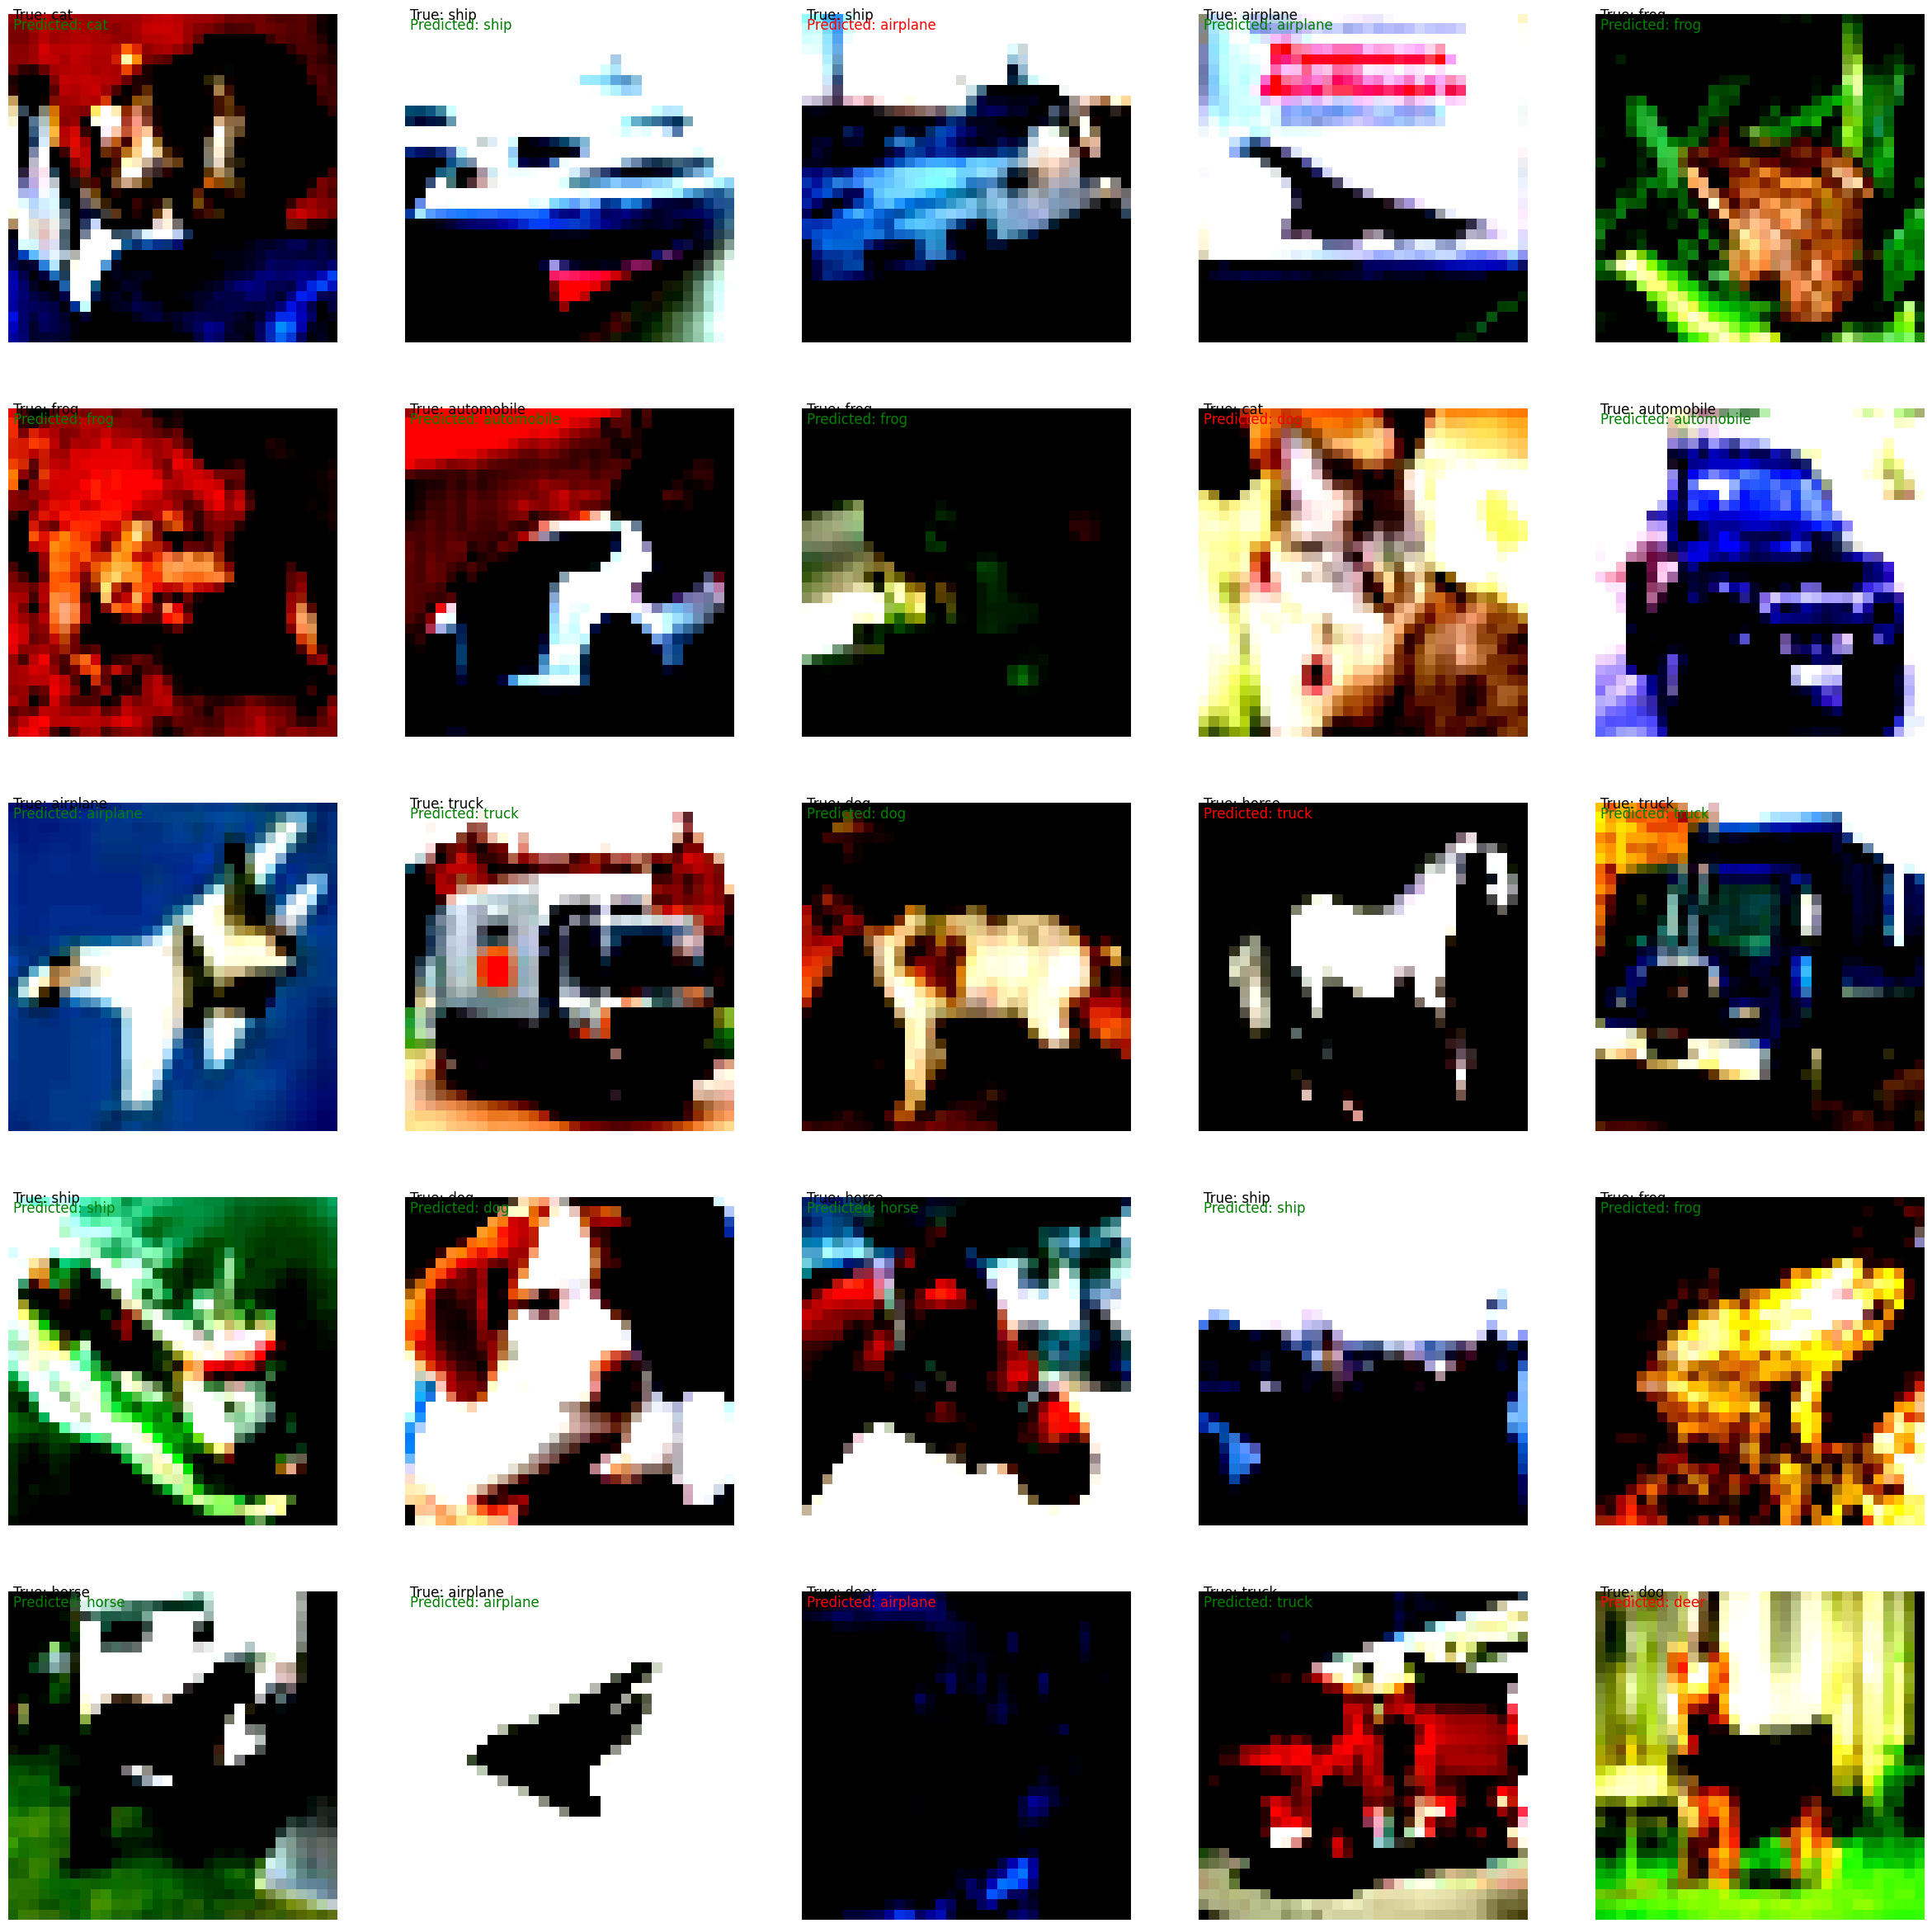

In [47]:
plt.figure(figsize=(30, 30))

number_images = (5,5)

num_samples = min(number_images[0]*number_images[1], len(x_test))

for i in range(num_samples):
    plt.subplot(number_images[0], number_images[1], i+1)
    plt.axis('off')
    
    true_label = label_list[y_test_labels[i]]
    predicted_label = label_list[final_pred[i]]
    
    colors = 'green' if true_label == predicted_label else 'red'
    
    
    plt.text(0, 0, f'True: {true_label}', color='black', fontsize=12)
    plt.text(0, 1, f'Predicted: {predicted_label}', color=colors, fontsize=12)
    plt.imshow(x_test[i])
    
plt.show()

## Custom Data Prediction

In [48]:
plt.figure(figsize=(30, 30))

import  urllib.request
import os
from PIL import Image

img_url = "https://t3.ftcdn.net/jpg/00/41/06/42/360_F_41064239_IaGdGyf1vxHFaNDS5K164OFOwiMe1hC9.jpg"

# Retrieve the image from the URL
filename, headers = urllib.request.urlretrieve(img_url)
img_path = os.path.join(os.getcwd(), filename)
img = Image.open(img_path)
img = img.resize((32,32))
img = np.array(img) / 255.0
img = np.expand_dims(img, axis=0)

# Predict the class of the image
probs = zfnet_model.predict(img)[0]

1/1 [==============================] - 0s 180ms/step


<Figure size 3000x3000 with 0 Axes>

In [49]:
# Get the predicted class index and name
pred_class_prob = np.argmax(probs)
pred_class_name = label_list[pred_class_prob]
max_prob = np.max(probs)
print(f'Predicted class: {pred_class_name}') 
print(f'Maximum probability: {max_prob}')

Predicted class: deer
Maximum probability: 1.0


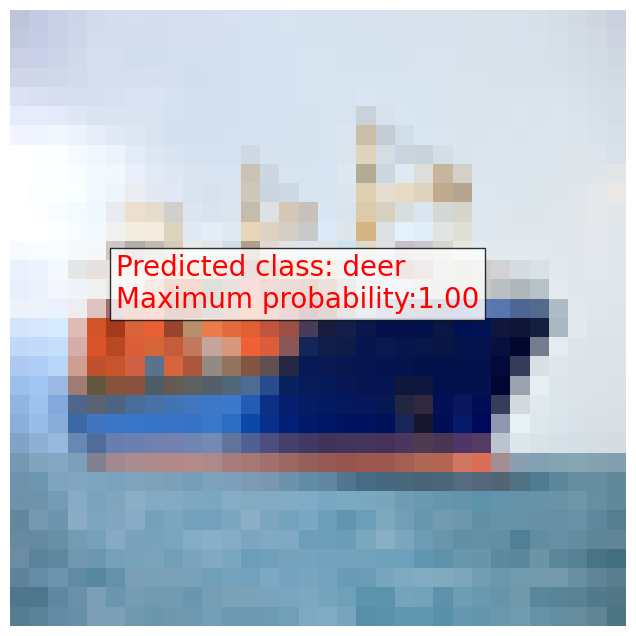

In [50]:
# Display the image with the predicted class and probability
plt.figure(figsize=(10,8))
plt.imshow(img[0])
plt.axis('off')
plt.text(5, 15, f'Predicted class: {pred_class_name}\nMaximum probability:{max_prob:.2f}', 
         fontsize=20, color='red', bbox=dict(facecolor='white',alpha=0.8)) 
plt.show()